# Bayesian Computations

## Bayesian inference in a nutshell
- uncertainty is represented by probability distributions
- prior belief is updated to yield posterior belief

prior belief about some parameter:
$$ p(\theta)$$

posterior belief:
$$ p(\theta | data)$$

## Bayesian belief revision

- priors: what you believe before
- likelihood: theories about data
- The joint probability of data and hypothesis

$$ p(\theta | data) =  p(\theta) \cdot \frac{p(data | \theta)}{p(data)}$$

## Example
Imagine two players are engaged in a card game. You observe that, over the
course of 9 games, player A wins 6 games, with player B winning 3. You being
to wonder whether this is just pure luck, or whether player A really is a
better player; in this case the probability of player A winning should be
greater than 0.5 (which means that either player is equally likely to win).

Let's explore this, using some simulations.

In [1]:
using Distributions, Plots, StatsBase, Turing

Player A has 6 wins

In [2]:
wins = 6

6

out of 9 games

In [3]:
games = 9

9

We know that the number of successes k in N games follows a binomial
distribution. If both players are equally matched, then the probability of
either winning a single game is 0.5. What is the probability of player A obtaining 6
wins if neither of the players is better than the other (the probability of
winning is 0.5)?

In [4]:
pdf(Binomial(games, 0.5), 6)

0.1640625000000001

The probability if this occuring is quite high.

The probability of obtaining 1, 2, 3, 4, 5 or 6 wins is

In [5]:
cdf(Binomial(games, 0.5), 6)

0.91015625

Therefore, the probability of exceeding 6 wins is

In [6]:
ccdf(Binomial(games, 0.5), 6)

0.08984375000000003

Does this approach seem familiar to you?

It would be far more informative to estimate the probability of player A
winning. The simplest approach would be to compute the ratio 6/9.

In [7]:
6/9

0.6666666666666666

This corresponds to the maximum likelihood estimate. But how certain are we
that the probability of A winning is 6/9, especially since A might win 6 out
games even if both are as good as each other.

In order to quantify our uncertainty, we want a distribution of probability
values. We can use Bayes theorem to obtain this distribution. This states that
the probability of A winning (let's call this $\theta$) after observing the
data is
$$ P(\theta|data) \propto P(data|\theta) * P(\theta) $$

define grid of possible probability values:

In [8]:
n_points = 100
p_grid =  range(0, stop = 1, length = n_points)

p_grid |> collect

100-element Array{Float64,1}:
 0.0
 0.010101010101010102
 0.020202020202020204
 0.030303030303030304
 0.04040404040404041
 0.050505050505050504
 0.06060606060606061
 0.0707070707070707
 0.08080808080808081
 0.09090909090909091
 ⋮
 0.9191919191919192
 0.9292929292929293
 0.9393939393939394
 0.9494949494949495
 0.9595959595959596
 0.9696969696969697
 0.9797979797979798
 0.98989898989899
 1.0

compute likelihood at each point in the grid
likelihood = [pdf(Binomial(games, p), wins) for p in p_grid]
or alternatively using map instead of a comprehension

In [9]:
likelihood = map(p -> pdf(Binomial(games, p), wins), p_grid)

100-element Array{Float64,1}:
 0.0
 8.654475678240112e-11
 5.371031648844559e-9
 5.9306700388237816e-8
 3.229187766433306e-7
 1.1933452849444134e-6
 3.450792795441393e-6
 8.423920446171768e-6
 1.8164633244226886e-5
 3.5624199943288674e-5
 ⋮
 0.026735040700166603
 0.019124215056526537
 0.012850321021124291
 0.007929388001202154
 0.004325976345696502
 0.0019433619583217707
 0.0006127494460057403
 8.145523272554033e-5
 0.0

define a uniform prior

In [10]:
prior = ones(length(p_grid));

As Uniform prior has been used, unstandardized posterior is equal to likelihood

compute product of likelihood and prior

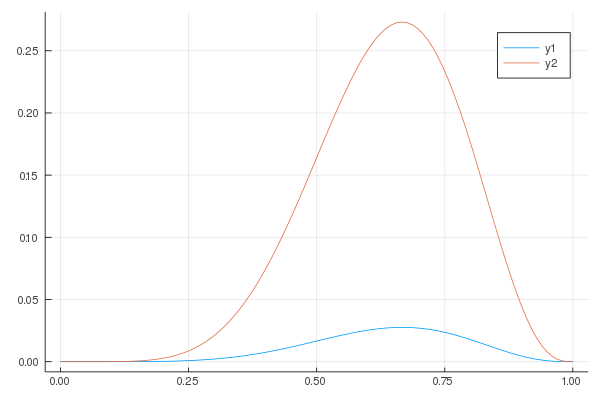

In [11]:
posterior = likelihood .* prior;

posterior /= sum(posterior)

plot(p_grid, posterior)
plot!(p_grid, likelihood)

plot!(p_grid, prior)
Just to confirm that 6/9 is the maximum likelihood esimtate:

In [12]:
maximum(likelihood)

pdf(Binomial(games, 6/9), wins)

isequal(maximum(likelihood), pdf(Binomial(games, 6/9), wins))

true

We can turn this into a function:

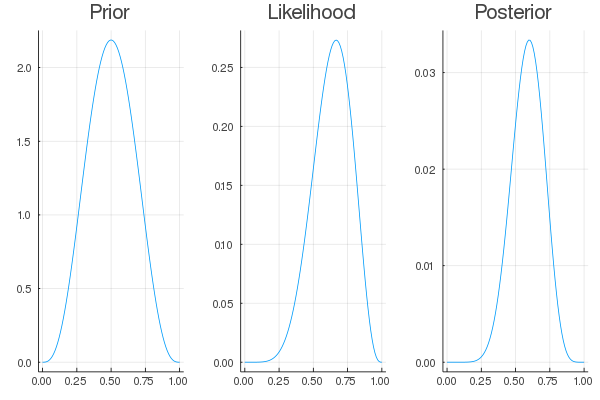

In [13]:
function compute_posterior(likelihood, prior)
    n_points = 100
    p_grid =  range(0, stop = 1, length = n_points)
    # compute product of likelihood and prior
    posterior = likelihood .* prior

    # standardize posterior
    # posterior = posterior ./ sum(posterior)
    posterior /= sum(posterior)

    p1 = plot(p_grid, prior, title = "Prior")
    p2 = plot(p_grid, likelihood , title = "Likelihood")
    p3 = plot(p_grid, posterior, title = "Posterior")

    plot(p1, p2, p3, layout=(1, 3), label="")
end


prior1 = ones(length(p_grid))
posterior1 = compute_posterior(likelihood, prior1)

prior2 = 2 * (p_grid .>= 0.5)
posterior2 = compute_posterior(likelihood, prior2)

prior3 = map(x -> pdf(Beta(40, 4), x), p_grid)
posterior3 = compute_posterior(likelihood, prior3)


prior4 = map(x -> pdf(Beta(4, 40), x), p_grid)
posterior4 = compute_posterior(likelihood, prior4)

prior5 = map(x -> pdf(Beta(4, 4), x), p_grid)
posterior5 = compute_posterior(likelihood, prior5)

## Analytic solution

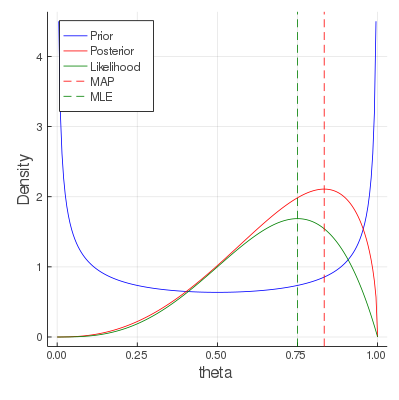

In [14]:
n = 4
h = 3
p = h/n

a, b = 10, 10                   # hyperparameters
prior = Beta(a, b)              # prior
plot(x -> pdf(prior, x), 0, 1)
posterior = Beta(h + a, n - h + b)         # posterior
plot!(x -> pdf(posterior, x), 0, 1)

function beta_binomial(n::Real, h::Real; a::Real, b::Real)
    # maximum likelihood
    p = h/n
    mu = mean(Binomial(n, p))

    # Bayesian
    thetas = range(0, stop=1, length=200)
    prior = pdf.(Beta(a, b), thetas)

    post = pdf.(Beta(h+a, n-h+b), thetas)

    likelihood = n * [pdf(Binomial(n, p), h) for p in thetas];
    plot(thetas,
         prior,
         size= [400, 400],
         label = "Prior",
         color = :blue,
         xlim = [0, 1],
         xlabel = "theta",
         ylabel = "Density")
    plot!(thetas, post, label = "Posterior", color = :red)
    plot!(thetas, likelihood, label="Likelihood", color = :green, legend = :topleft)
    vline!([(h+a-1)/(n+a+b-2)], color = :red, linestyle = :dash, label="MAP")
    vline!([mu / n], color = :green, linestyle = :dash, label="MLE")
end

beta_binomial(100, 80, a = 10, b = 10)

beta_binomial(4, 3, a = 10, b = 10)

beta_binomial(4, 3, a = 2, b = 2)

beta_binomial(4, 3, a = 1, b = 1)

beta_binomial(4, 3, a = 0.5, b = 0.5)

## Metropolis-Hastings
Above we saw an example using a grid search, and the analytic solution. In
most cases, grid is not possible, and the analytic solution is not available.

Portion of accepted steps = 0.1941


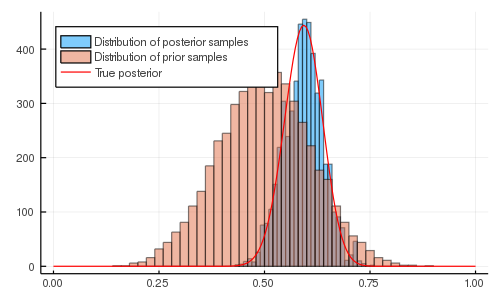

In [15]:
function target(likelihood::UnionAll, prior::Distribution, n, h, θ)
    if (θ < 0 ||  θ > 1)
        return 0
    else
        return (pdf(likelihood(n, θ), h) * pdf(prior, θ))
    end
end

n = 100
h = 61
a = 10
b = 10

likelihood = Binomial
prior = Beta(a, b)

σ = 0.3

naccept = 0
niters = 10000
θ = rand(prior)
samples = zeros(niters + 1)
samples[1] = θ

for i ∈ 1:niters
    global θ, naccept
    θ_proposed = θ + rand(Normal(0, σ))
    ρ = min(1, target(likelihood, prior, n, h, θ_proposed)/target(likelihood, prior, n, h, θ ))
    u = rand(Uniform(0, 1))
    if u < ρ
            naccept += 1
            θ = θ_proposed
    end
    samples[i+1] = θ
end


println("Portion of accepted steps = " * string(naccept/niters))

nmcmc = Int(round(length(samples)/2))

post = Beta(h+a, n-h+b)
thetas = range(0, stop=1, length=200)

histogram(samples[nmcmc:length(samples)],
          size = [500, 300],
          label="Distribution of posterior samples", alpha = 0.5,
          legend = :topleft)
histogram!(rand(prior, nmcmc),
          label = "Distribution of prior samples", alpha = 0.5)
plot!(thetas, 50*[pdf(post, theta) for theta in thetas], color = :red, label = "True posterior")

## Turing: A probabilistic programming language

In [16]:
using Turing

Let's simulate some more coin tossing. We have 100 tosses, and 61 successes.

In [17]:
n = 100    # number of trials
k = 61     # number of successes

61

We'll assume a prior on the probability of success:

In [18]:
plot(x -> pdf(Beta(2, 2), x), 0, 1,
     title = "Beta(2, 2)", legend = :none)

@model coin(n, k) = begin
    # prior
    θ ~ Beta(2, 2)
    # likelihood
    k ~ Binomial(n, θ)
end

DynamicPPL.ModelGen{Main.##344.var"###generator#415",(:n, :k),(),Tuple{}}(Main.##344.##generator#415, NamedTuple())

sample 4 chains in parallel, each with 2000 samples

┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /Users/andrew/.julia/packages/Turing/vFp7z/src/inference/hmc.jl:626
Sampling (4 threads)   0%|                              |  ETA: N/A
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/andrew/.julia/packages/AdvancedHMC/WJCQA/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/andrew/.julia/packages/AdvancedHMC/WJCQA/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/andrew/.julia/packages/AdvancedHMC/WJCQA/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, fals

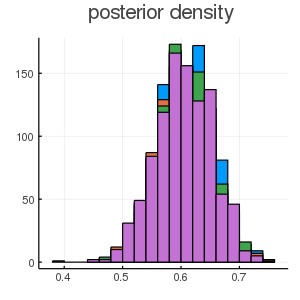

In [19]:
chains = sample(coin(n, k), NUTS(), MCMCThreads(), 2000, 4);

describe(chains)
show(chains)

meanplot(chains)

samples = get(chains, :θ)

histogram(samples.θ, size = [300, 300], legend = false, title = "posterior density")

traceplot

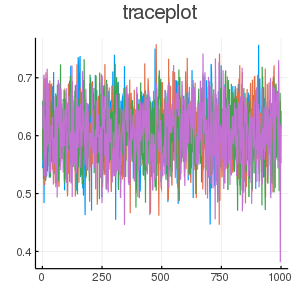

In [20]:
plot(samples.θ, size = [300, 300], legend = false, title = "traceplot")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*